# 7. BERT Fine-Tuning 

## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from transformers import AdamW
#specify GPU
device = torch.device("cuda")


# 2. Load Dataset

In [3]:
bert_df = pd.read_csv("../data/processed/balanced_fake_news_dataset.csv")

In [4]:
bert_df.head()

,text,label,original_label,dataset,clean_text,tokens,processed_text,sentiment
0,Says comprehensive immigration reform will add...,0,half-true,LIAR,says comprehensive immigration reform will add...,"['say', 'comprehensive', 'immigration', 'refor...",say comprehensive immigration reform add billi...,0.2500
1,Ellen DeGeneres makes joke about Jennifer Anis...,0,0,FakeNewsNet_Minimal,ellen degeneres makes joke about jennifer anis...,"['ellen', 'degeneres', 'make', 'joke', 'jennif...",ellen degeneres make joke jennifer aniston mar...,0.2960
2,"When we lower tax rates, we generate more in r...",0,half-true,LIAR,when we lower tax rates we generate more in re...,"['lower', 'tax', 'rate', 'generate', 'revenue'...",lower tax rate generate revenue happened reaga...,-0.2960
3,Karma it s a beautiful thing A massive makeshi...,0,0,ISOT,karma it s a beautiful thing a massive makeshi...,"['karma', 'beautiful', 'thing', 'massive', 'ma...",karma beautiful thing massive makeshift refuge...,0.5719
4,Ellen DeGeneres' wife Portia de Rossi makes he...,0,0,FakeNewsNet_Minimal,ellen degeneres wife portia de rossi makes her...,"['ellen', 'degeneres', 'wife', 'portia', 'de',...",ellen degeneres wife portia de rossi make cry ...,-0.0516


# 3. Test Train Split

In [5]:
# Train-Validation-Test set split into 70 : 15 :15 ratio
#Train -Temp split

train_text, temp_text, train_labels, temp_labels = train_test_split(bert_df['processed_text'], bert_df['label'],
                                                                    random_state=2025,
                                                                    test_size=0.3,
                                                                    stratify=bert_df['label'])

In [6]:
val_text, test_text, val_labels, test_labels = train_test_split( temp_text, temp_labels,
                                                                test_size=0.5,       # split 30% into 15% val + 15% test
                                                                random_state=2018,
                                                                stratify=temp_labels
)


In [7]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Text(0, 0.5, 'Number of Texts')

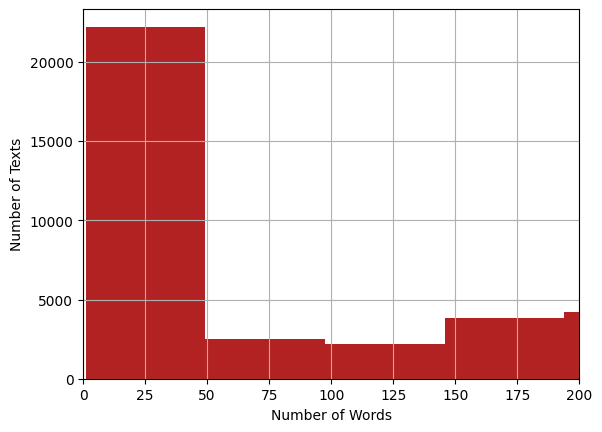

In [8]:
# plot histograms of the number of words in train data processed text
seq_len = [len(processed_text.split()) for processed_text in train_text]

pd.Series(seq_len).hist(bins = 100, color = 'firebrick')
plt.xlim(0, 200)  # Adjust as needed
plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')

# 3. Prepare Input Data

In [9]:
# Majority of titles above have word length under 50.
MAX_LENGHT = 50
# Tokenize and encode sequences in the trair set
tokens_train = tokenizer.batch_encode_plus( 
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length = True ,
    truncation = True
)

#tokenize and encode sequences in the validation set

tokens_val  = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length =True,
    truncation =True
)

# tokenize and encode sequences in the test set

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length =MAX_LENGHT,
    pad_to_max_length = True,
    truncation =True
)

In [10]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())



In [11]:
# Data loader structure definition 

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32                                                                         #define a batch size         

train_data = TensorDataset(train_seq, train_mask, train_y)                              #wrap tensors        
train_sampler = RandomSampler(train_data)                                               #sampler for sampling data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) # dataloader for train set 

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)       # dataloader for validation set 


# 4. Freeze Layers

In [12]:
# freezing the parameters  and defining trainable BERT structure 

for param in bert.parameters():
    param.requires_grad = False             # False here means gradient need not be computed 

# 5. Define Model Architecture

In [13]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer

optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2

# 6. Defining training and evaluation functions

In [14]:

def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

# 7. Model training

In [39]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of  1,357.
  Batch   100  of  1,357.
  Batch   150  of  1,357.
  Batch   200  of  1,357.
  Batch   250  of  1,357.
  Batch   300  of  1,357.
  Batch   350  of  1,357.
  Batch   400  of  1,357.
  Batch   450  of  1,357.
  Batch   500  of  1,357.
  Batch   550  of  1,357.
  Batch   600  of  1,357.
  Batch   650  of  1,357.
  Batch   700  of  1,357.
  Batch   750  of  1,357.
  Batch   800  of  1,357.
  Batch   850  of  1,357.
  Batch   900  of  1,357.
  Batch   950  of  1,357.
  Batch 1,000  of  1,357.
  Batch 1,050  of  1,357.
  Batch 1,100  of  1,357.
  Batch 1,150  of  1,357.
  Batch 1,200  of  1,357.
  Batch 1,250  of  1,357.
  Batch 1,300  of  1,357.
  Batch 1,350  of  1,357.

Evaluating...
  Batch    50  of    291.
  Batch   100  of    291.
  Batch   150  of    291.
  Batch   200  of    291.
  Batch   250  of    291.

Training Loss: 0.655
Validation Loss: 0.612

 Epoch 2 / 2
  Batch    50  of  1,357.
  Batch   100  of  1,357.
  Batch   150  of  1,357.
  

# 8. Model performance

In [15]:
# load weights of best model
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [16]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      4648
           1       0.73      0.81      0.77      4657

    accuracy                           0.76      9305
   macro avg       0.76      0.76      0.75      9305
weighted avg       0.76      0.76      0.75      9305



# 9. Fake News Predictions

In [17]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([0, 1, 1, 1], dtype=int64)

In [20]:
torch.save(model.state_dict(), "../models/bert_model.pth")

In [22]:
tokenizer.save_pretrained("../models/bert_model_tokenizer")


('../models/bert_model_tokenizer\\tokenizer_config.json',
 '../models/bert_model_tokenizer\\special_tokens_map.json',
 '../models/bert_model_tokenizer\\vocab.txt',
 '../models/bert_model_tokenizer\\added_tokens.json',
 '../models/bert_model_tokenizer\\tokenizer.json')